Sources:

http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

# Feature Extraction from VGG16

First let's look at the images we will be working with.

Found 1000 images belonging to 2 classes.


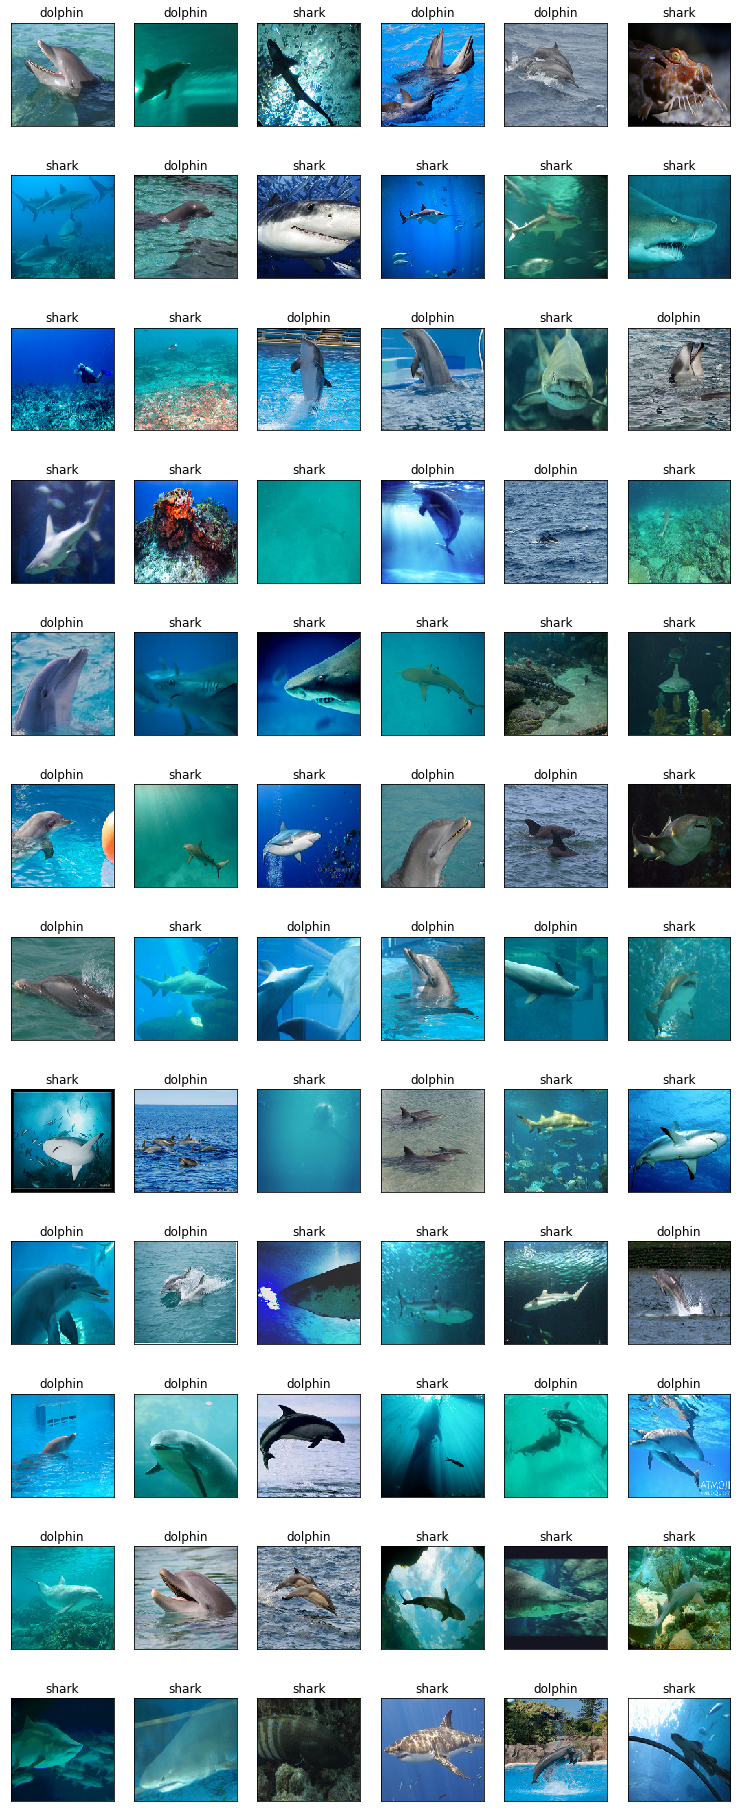

In [4]:
%matplotlib inline

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

test_dir = '../data/test'
test_datagen = ImageDataGenerator(rescale=1./255)
plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (150, 150, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] == 1 else 'dolphin')
   
    if i > num_images:
        break
        
        
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, titles, n_row=12, n_col=6)

Set up model

In [1]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# Create model with VGG as base, and classifier model on top
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Freeze conv blocks
conv_base.trainable = False



Using TensorFlow backend.


Set up data generator with data augmentation

In [2]:

train_dir = '../data/train'
validation_dir = '../data/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [3]:
from keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

Now fit the model using the data generator

In [4]:
%%time

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/30
100/100 [==============================] - 17s - loss: 0.2929 - acc: 0.8745 - val_loss: 0.1457 - val_acc: 0.9440
Epoch 2/30
100/100 [==============================] - 15s - loss: 0.1709 - acc: 0.9335 - val_loss: 0.1849 - val_acc: 0.9320
Epoch 3/30
100/100 [==============================] - 15s - loss: 0.1472 - acc: 0.9485 - val_loss: 0.1051 - val_acc: 0.9580
Epoch 4/30
100/100 [==============================] - 15s - loss: 0.1137 - acc: 0.9630 - val_loss: 0.0957 - val_acc: 0.9690
Epoch 5/30
100/100 [==============================] - 15s - loss: 0.1053 - acc: 0.9665 - val_loss: 0.0884 - val_acc: 0.9740
Epoch 6/30
100/100 [==============================] - 15s - loss: 0.0937 - acc: 0.9670 - val_loss: 0.0886 - val_acc: 0.9640
Epoch 7/30
100/100 [==============================] - 15s - loss: 0.0811 - acc: 0.9720 - val_loss: 0.1474 - val_acc: 0.9470
Epoch 8/30
100/100 [==============================] - 15s - loss: 0.0705 - acc: 0.9765 - val_loss: 0.0748 - val_acc: 0.9700
Epoch 9/

In [5]:
model.save('../models/dolphins_sharks_frozen_conv.h5')

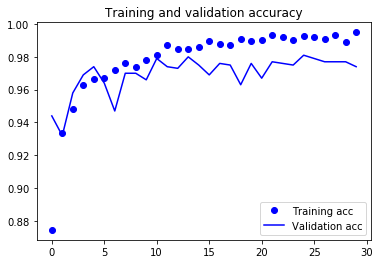

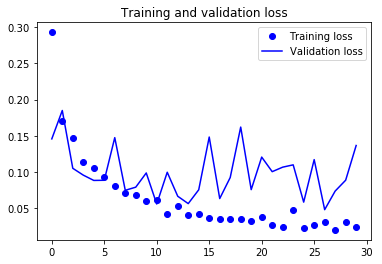

In [6]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tune last convolutional block

In [7]:
# Top model has already been trained above, so now unfreeze
# the last convolutional block to fine tune it

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
%%time 

# Recompile with a lower learning rate for RMS prop to
# limit the magnitude of the modifications made to the representations
# of the 3 layers we are fine tuning
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 16s - loss: 0.0082 - acc: 0.9975 - val_loss: 0.1402 - val_acc: 0.9780
Epoch 2/100
100/100 [==============================] - 14s - loss: 0.0069 - acc: 0.9980 - val_loss: 0.1516 - val_acc: 0.9770
Epoch 3/100
100/100 [==============================] - 14s - loss: 0.0030 - acc: 0.9990 - val_loss: 0.1539 - val_acc: 0.9780
Epoch 4/100
100/100 [==============================] - 14s - loss: 5.7466e-04 - acc: 1.0000 - val_loss: 0.1834 - val_acc: 0.9760
Epoch 5/100
100/100 [==============================] - 14s - loss: 0.0100 - acc: 0.9980 - val_loss: 0.1144 - val_acc: 0.9830
Epoch 6/100
100/100 [==============================] - 14s - loss: 0.0054 - acc: 0.9980 - val_loss: 0.1344 - val_acc: 0.9770
Epoch 7/100
100/100 [==============================] - 14s - loss: 0.0083 - acc: 0.9985 - val_loss: 0.1754 - val_acc: 0.9790
Epoch 8/100
100/100 [==============================] - 14s - loss: 0.0054 - acc: 0.9970 - val_loss: 0.1210 - val_acc: 0.9

In [9]:
model.save('../models/dolphins_sharks_fine_tune.h5')

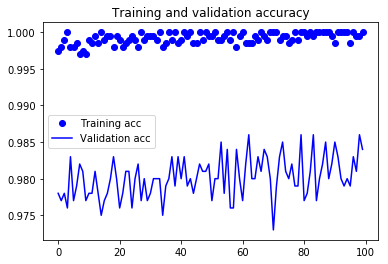

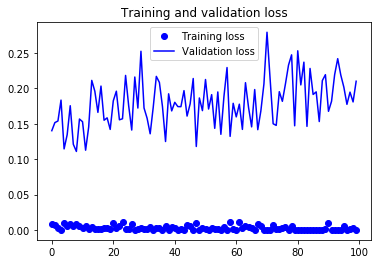

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
test_dir = '../data/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.985999997854


Found 1000 images belonging to 2 classes.


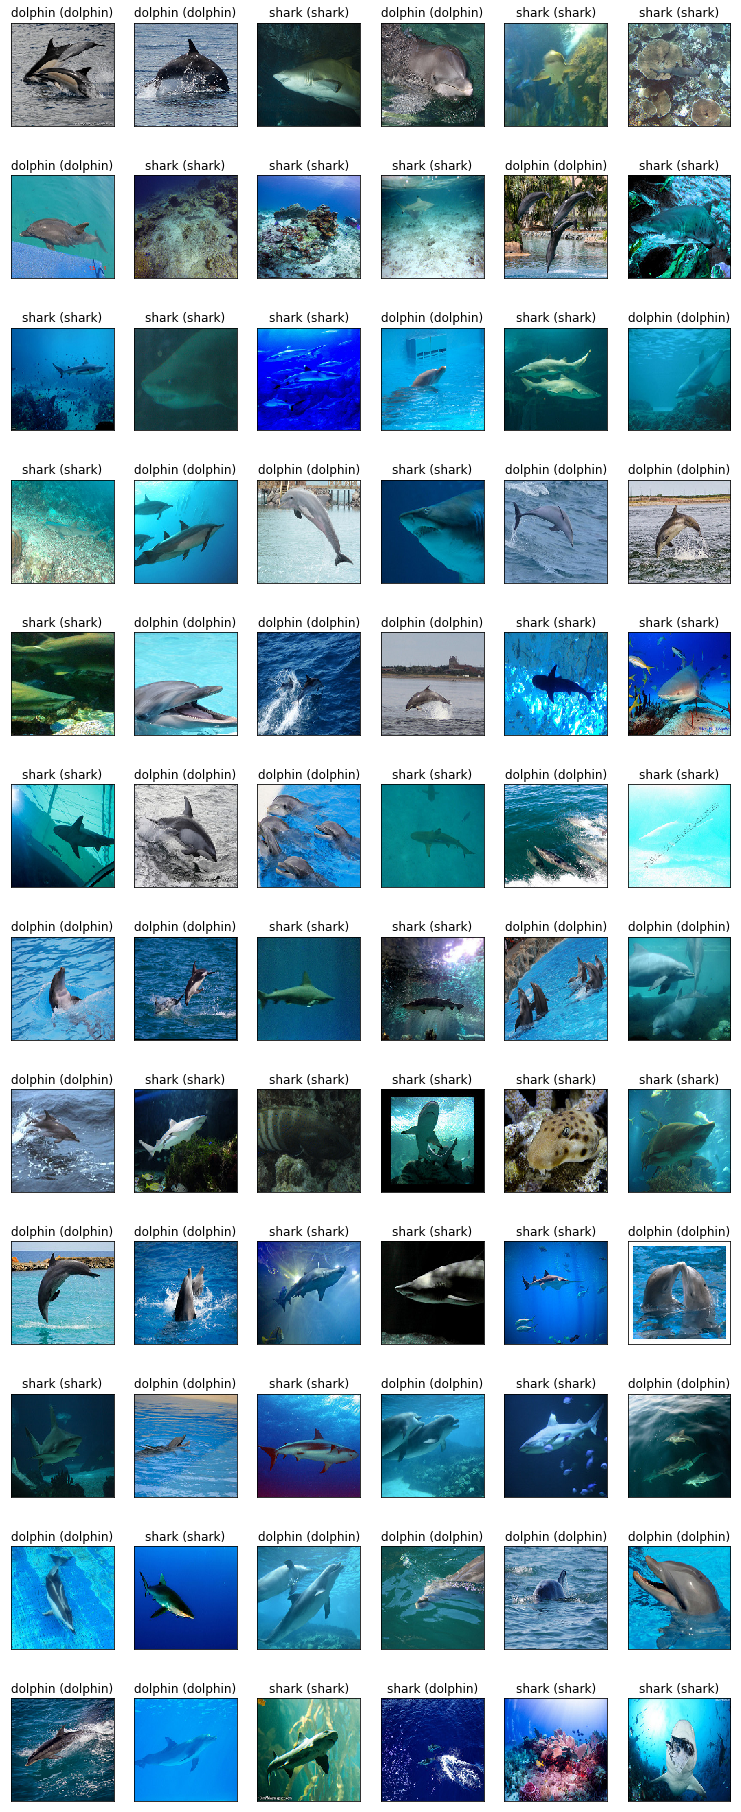

In [12]:
%matplotlib inline

import numpy as np

plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
predictions = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (150, 150, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] == 1 else 'dolphin')
    predictions.append('shark' if model.predict(inputs) == 1 else 'dolphin')
   
    if i > num_images:
        break
        
for i in range(num_images):
    predictions[i] += ' (%s)' % titles[i]
        
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, predictions, n_row=12, n_col=6)